In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torchtext.vocab import build_vocab_from_iterator
import re

In [4]:
# 데이터 로드 및 전처리
def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    data['content'] = data['content'].fillna("").astype(str)
    return data

In [5]:
# 텍스트 전처리 함수
def preprocess_text(text):
    if isinstance(text, list):
        text = " ".join(text)
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text.split()

# 데이터셋 클래스 정의
class ReviewDataset(Dataset):
    def __init__(self, content, score):
        self.content = content
        self.score = score

    def __len__(self):
        return len(self.content)

    def __getitem__(self, idx):
        content = preprocess_text(self.content.iloc[idx])  # preprocess_text 함수 직접 호출
        score = self.score.iloc[idx]
        return content, score

# 텍스트를 인덱스로 변환하는 파이프라인
class TextPipeline:
    def __init__(self, vocab):
        self.vocab = vocab

    def __call__(self, text):
        tokens = preprocess_text(text)
        return [self.vocab[token] for token in tokens if token in self.vocab]

In [6]:
# 개선된 LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=2, dropout_rate=0.5):
        super(LSTMModel, self).__init__()
        
        # 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_dropout = nn.Dropout(dropout_rate)
        
        # LSTM 레이어
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            num_layers=n_layers, 
            batch_first=True,
            dropout=dropout_rate if n_layers > 1 else 0,
            bidirectional=True
        )
        
        # 출력 레이어
        self.fc_dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim * 2, hidden_dim)  # bidirectional이므로 hidden_dim * 2
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # 임베딩 레이어
        embedded = self.embedding(x)
        embedded = self.embedding_dropout(embedded)
        
        # LSTM 레이어
        lstm_out, (hidden, cell) = self.lstm(embedded)
        
        # hidden states 연결 (bidirectional)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        
        # 출력 레이어
        dense1 = self.fc_dropout(hidden)
        dense1 = self.fc(dense1)
        dense1 = self.relu(dense1)
        
        # 최종 출력
        output = self.output(dense1)
        
        return output

In [7]:
# 배치 생성을 위한 collate 함수
def collate_batch(batch, text_pipeline, vocab):
    texts, labels = zip(*batch)
    texts = [torch.tensor(text_pipeline(text), dtype=torch.long) for text in texts]
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=vocab['<unk>'])
    labels = torch.tensor(labels, dtype=torch.long)
    return texts_padded, labels


In [50]:
#train_model 함수수정
# 시간추가 했다가 빼고 손실 변화 그래프 실시간 출력함

import matplotlib.pyplot as plt

def train_model(model, train_loader, criterion, optimizer, device, num_epochs):
    model.train()
    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0

        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            
            optimizer.zero_grad()
            output = model(texts)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            # 정확도 계산
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # 에포크별 손실 값과 정확도 계산
        avg_loss = total_loss / len(train_loader)
        accuracy = 100 * correct / total

        # 손실 값과 정확도 저장
        epoch_losses.append(avg_loss)
        epoch_accuracies.append(accuracy)

        # 에포크별 결과 출력
        print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

        # 실시간 그래프 업데이트
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epoch_losses, label='Loss')
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.ylim(min(epoch_losses) - 0.1, max(epoch_losses) + 0.1)  # Y축 범위 설정
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epoch_accuracies, label='Accuracy', color='orange')
        plt.title('Training Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.ylim(min(epoch_accuracies) - 1, max(epoch_accuracies) + 1)  # Y축 범위 설정
        plt.legend()

        plt.show()

In [9]:
#train_model 시간 추가 전 

def train_model(model, train_loader, criterion, optimizer, device, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0
        
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            
            optimizer.zero_grad()
            output = model(texts)
            loss = criterion(output, labels)
            loss.backward()
            
            # Gradient Clipping 추가
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            
            optimizer.step()
            
            total_loss += loss.item()
            
            # 정확도 계산
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        avg_loss = total_loss / len(train_loader)
        accuracy = 100 * correct / total
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [23]:
def predict_review(model, text, text_pipeline, device):
    model.eval()
    with torch.no_grad():
        tensor_review = torch.tensor(text_pipeline(text), dtype=torch.long).unsqueeze(0).to(device)
        output = model(tensor_review)
        prediction = output.argmax(1).item()
        probabilities = torch.softmax(output, dim=1)
        confidence = probabilities.max().item()
    return prediction, confidence

def main():
    # 설정
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    BATCH_SIZE = 16  # 배치 사이즈 줄임
    EMBED_DIM = 128  # 임베딩 차원 증가
    HIDDEN_DIM = 256  # 은닉층 차원 증가
    NUM_EPOCHS = 10
    LEARNING_RATE = 0.001  # 학습률 조정
    N_LAYERS = 2  # LSTM 레이어 수
    
    print(f"Using device: {DEVICE}")      

In [24]:
def load_and_preprocess_data(file_path):
    # 데이터 로드
    try:
        data = pd.read_csv(file_path)
        data['content'] = data['content'].fillna("").astype(str)  # NaN 처리 및 문자열로 변환
        return data
    except FileNotFoundError:
        print("Error: 데이터 파일을 찾을 수 없습니다.")
        return None
    except Exception as e:
        print(f"Error: 데이터 로드 중 오류 발생 - {str(e)}")
        return None

In [36]:
# 데이터 분할 함수에 레이블 값 0 조정 추가 (문제생기면 이거 지우면 됨)
def split_data(data, test_size=0.2, random_state=42):
    # 데이터 분할
    train_content, test_content, train_score, test_score = train_test_split(
        data['content'], data['score'], test_size=test_size, random_state=random_state
    )

    # 레이블 값을 0부터 시작하도록 조정
    train_score -= train_score.min()
    test_score -= test_score.min()
    
    return train_content, test_content, train_score, test_score

In [25]:
def split_data(data, test_size=0.2, random_state=42):
    # 데이터 분할
    train_content, test_content, train_score, test_score = train_test_split(
        data['content'], data['score'], test_size=test_size, random_state=random_state
    )
    return train_content, test_content, train_score, test_score

def build_vocab(train_content):
    def yield_tokens(content):
        for text in content:
            yield preprocess_text(text)
    
    vocab = build_vocab_from_iterator(yield_tokens(train_content), specials=['<unk>'])
    vocab.set_default_index(vocab['<unk>'])
    return vocab

In [37]:
def create_dataloader(content, score, batch_size, text_pipeline, vocab, shuffle=True):
    dataset = ReviewDataset(content, score)  # 수정된 부분

    loader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=shuffle,
        collate_fn=lambda b: collate_batch(b, text_pipeline, vocab)
    )
    return loader

In [38]:
def initialize_model(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, device):
    model = LSTMModel(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=hidden_dim,
        output_dim=output_dim,
        n_layers=n_layers
    ).to(device)
    return model

--main을 쪼갰음--

In [39]:
# 설정 함수

def set_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_hyperparameters():
    return {
        "BATCH_SIZE": 32,
        "EMBED_DIM": 128,
        "HIDDEN_DIM": 256,
        "NUM_EPOCHS": 10,
        "LEARNING_RATE": 0.001,
        "N_LAYERS": 2
    }

In [40]:
# 데이터 로드 및 전처리 함수
def load_data(file_path):
    data = load_and_preprocess_data(file_path)
    if data is None:
        raise ValueError("데이터 준비 중 오류가 발생했습니다.")
    return data

In [41]:
# 데이터 준비 함수
def prepare_data(data):
    train_content, test_content, train_score, test_score = split_data(data)
    return train_content, test_content, train_score, test_score

In [42]:
# 어휘 사전 및 데이터 로더 생성 함수
def create_vocab_and_pipeline(train_content):
    vocab = build_vocab(train_content)
    text_pipeline = TextPipeline(vocab)
    return vocab, text_pipeline

def create_dataloaders(train_content, test_content, train_score, test_score, batch_size, text_pipeline, vocab):
    train_loader = create_dataloader(train_content, train_score, batch_size, text_pipeline, vocab, shuffle=True)
    test_loader = create_dataloader(test_content, test_score, batch_size, text_pipeline, vocab, shuffle=False)
    return train_loader, test_loader

In [43]:
# 모델 초기화 및 손실 함수 정의 함수
def initialize_training_model(vocab, embedding_dim, hidden_dim, output_dim, n_layers, device):
    model = initialize_model(
        vocab_size=len(vocab),
        embedding_dim=embedding_dim,
        hidden_dim=hidden_dim,
        output_dim=output_dim,
        n_layers=n_layers,
        device=device
    )
    model.to(device)
    return model

def set_criterion_and_optimizer(model, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return criterion, optimizer

In [44]:
# 예측 테스트 및 모델 저장 함수
def test_predictions(model, text_pipeline, device):
    test_reviews = [
        "This movie is great and I really enjoyed watching it",
        "This was a terrible waste of time",
        "It was okay, nothing special but not bad either"
    ]
    
    print("\nTest Predictions:")
    for review in test_reviews:
        predicted_score, confidence = predict_review(model, review, text_pipeline, device)
        print(f'\nReview: "{review}"')
        print(f'Predicted Score: {predicted_score}')
        print(f'Confidence: {confidence:.2%}')

def save_model(model, optimizer, vocab):
    try:
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'vocab': vocab,
        }, 'review_model.pth')
        print("\nModel saved successfully")
    except Exception as e:
        print(f"Error: 모델 저장 중 오류 발생 - {str(e)}")

In [45]:
import time

Using device: cpu
Data loaded in 0.37 seconds
Data split in 0.01 seconds
Unique train labels: {0, 1, 2, 3, 4}
Epoch [1/10] - Loss: 1.0995, Accuracy: 60.06%


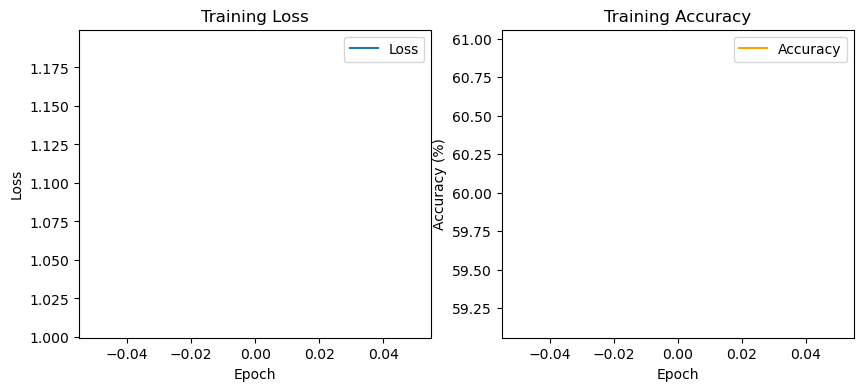

Epoch [2/10] - Loss: 0.9806, Accuracy: 64.25%


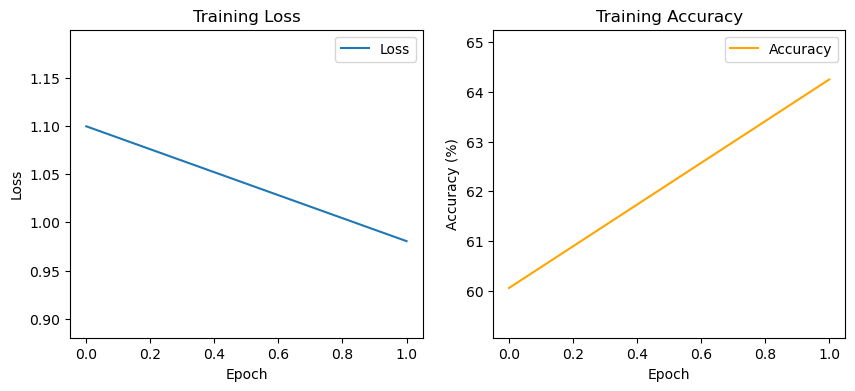

Epoch [3/10] - Loss: 0.9450, Accuracy: 65.17%


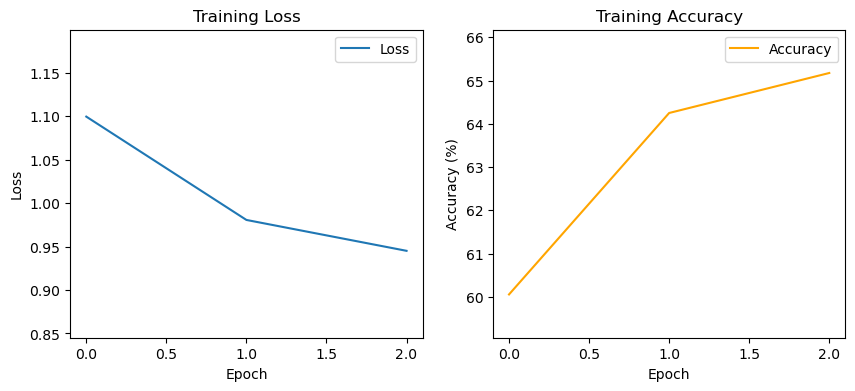

Epoch [4/10] - Loss: 0.9201, Accuracy: 65.93%


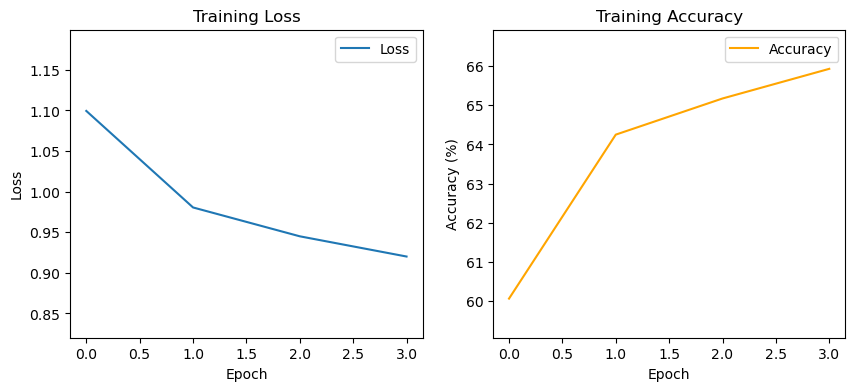

Epoch [5/10] - Loss: 0.9050, Accuracy: 66.39%


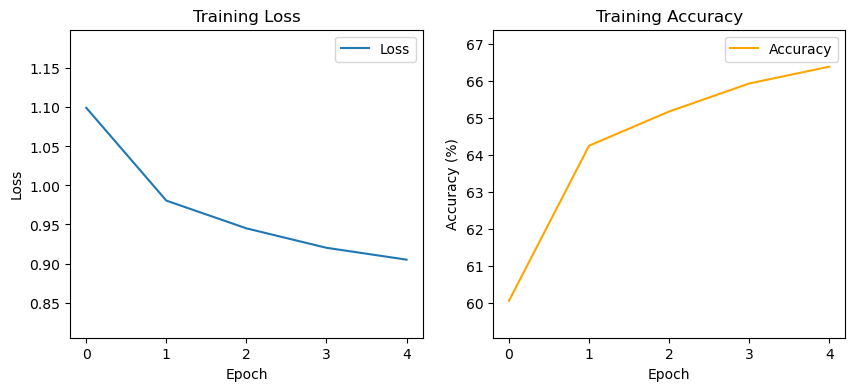

Epoch [6/10] - Loss: 0.8900, Accuracy: 66.89%


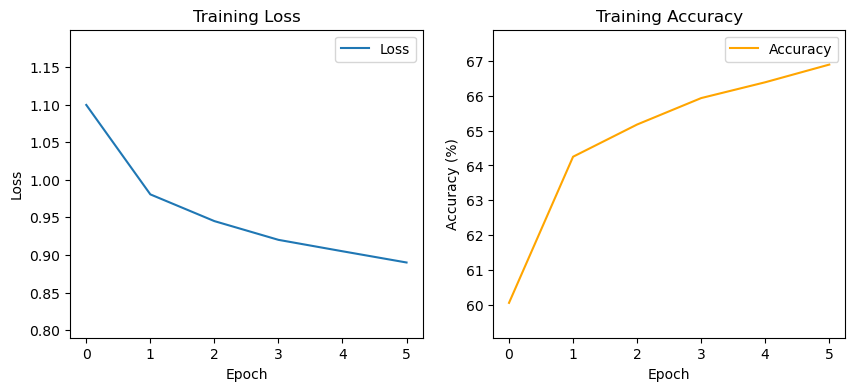

Epoch [7/10] - Loss: 0.8794, Accuracy: 67.14%


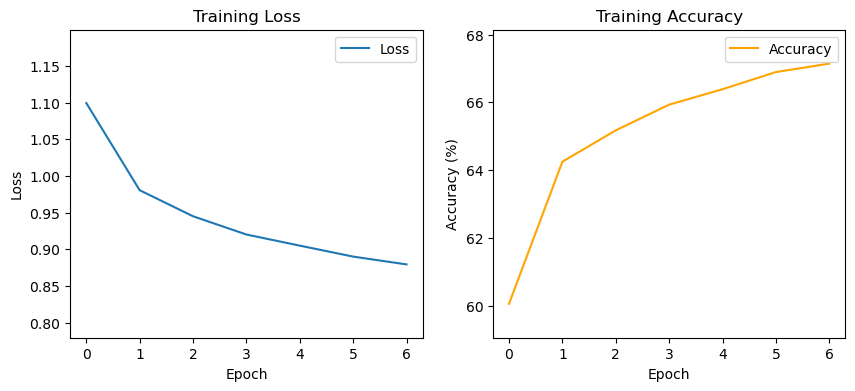

Epoch [8/10] - Loss: 0.8698, Accuracy: 67.55%


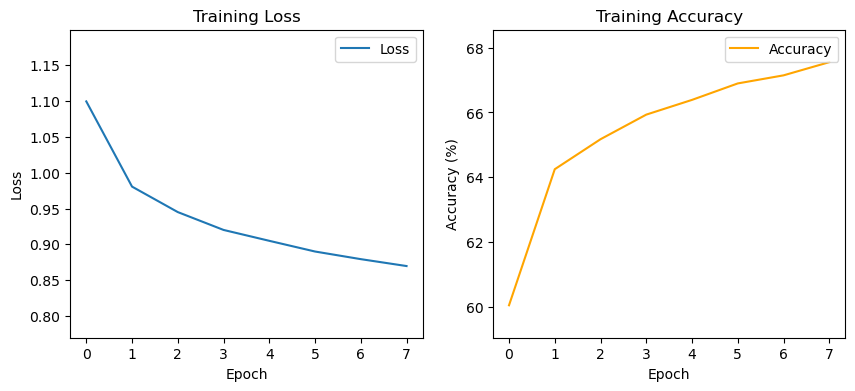

Epoch [9/10] - Loss: 0.8625, Accuracy: 67.77%


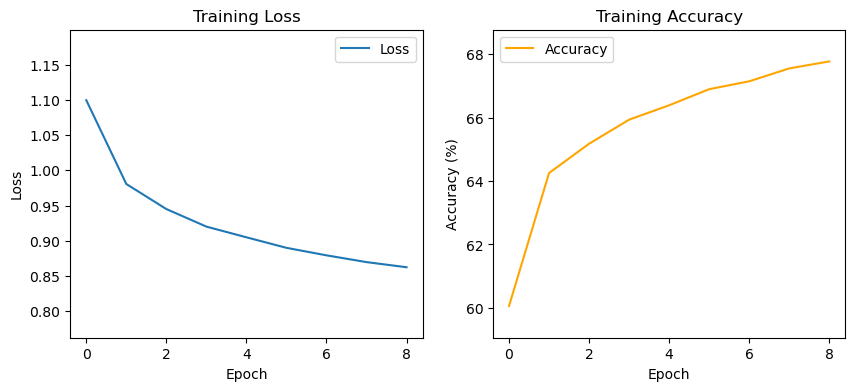

Epoch [10/10] - Loss: 0.8557, Accuracy: 67.99%


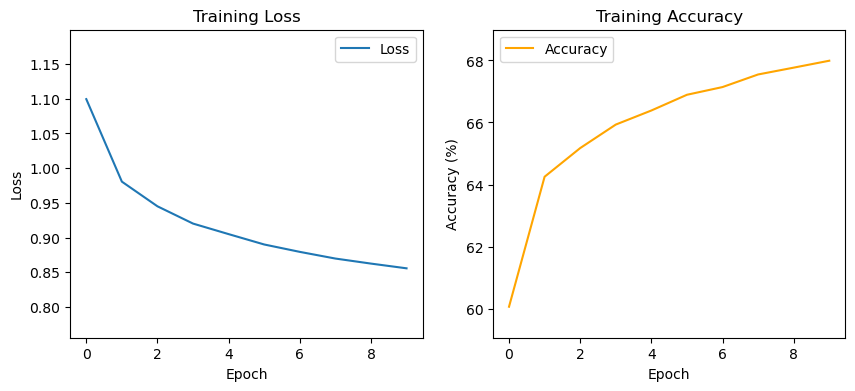


Test Predictions:

Review: "This movie is great and I really enjoyed watching it"
Predicted Score: 4
Confidence: 85.04%

Review: "This was a terrible waste of time"
Predicted Score: 0
Confidence: 97.14%

Review: "It was okay, nothing special but not bad either"
Predicted Score: 3
Confidence: 23.91%

Model saved successfully


In [51]:
# 최종 main 함수
def main():
    # 설정
    DEVICE = torch.device('cpu')
    hyperparams = get_hyperparameters()
    
    print(f"Using device: {DEVICE}")
    
    try:
        # 데이터 로드 및 전처리
        start_time = time.time()
        data = load_data('netflix_reviews.csv')
        print(f"Data loaded in {time.time() - start_time:.2f} seconds")
        
        # 데이터 분할 (여기서 레이블 값도 조정됨)
        start_time = time.time()
        train_content, test_content, train_score, test_score = split_data(data)
        print(f"Data split in {time.time() - start_time:.2f} seconds")
        print(f"Unique train labels: {set(train_score)}")

        # 어휘 사전 및 텍스트 파이프라인 생성
        vocab, text_pipeline = create_vocab_and_pipeline(train_content)

        # 데이터 로더 생성
        train_loader, test_loader = create_dataloaders(
            train_content, test_content, train_score, test_score,
            hyperparams["BATCH_SIZE"], text_pipeline, vocab
        )

        # 모델 초기화
        model = initialize_training_model(
            vocab=vocab,
            embedding_dim=hyperparams["EMBED_DIM"],
            hidden_dim=hyperparams["HIDDEN_DIM"],
            output_dim=len(set(train_score)),
            n_layers=hyperparams["N_LAYERS"],
            device=DEVICE
        ).to(DEVICE)

        # 손실 함수와 옵티마이저 정의
        criterion, optimizer = set_criterion_and_optimizer(model, hyperparams["LEARNING_RATE"])
        
        # 모델 학습
        train_model(model, train_loader, criterion, optimizer, DEVICE, hyperparams["NUM_EPOCHS"])
        
        # 예측 테스트
        test_predictions(model, text_pipeline, DEVICE)

        # 모델 저장
        save_model(model, optimizer, vocab)
    
    except Exception as e:
        print(f"Error: {str(e)}")

if __name__ == "__main__":
    main()

In [52]:
import torch

# 모델 로드 함수 정의
def load_model(filepath, model_class, device):
    checkpoint = torch.load(filepath, map_location=device)
    model = model_class(
        vocab_size=len(checkpoint['vocab']),
        embedding_dim=128,  # 이전에 설정했던 값으로 변경
        hidden_dim=256,     # 이전에 설정했던 값으로 변경
        output_dim=5,       # 예측할 점수의 개수 (0~4)
        n_layers=2          # 이전에 설정했던 레이어 수로 변경
    ).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model, checkpoint['vocab']

# 예측 함수 정의
def predict_review(model, review, text_pipeline, device):
    model.eval()
    with torch.no_grad():
        tensor_review = torch.tensor(text_pipeline(review), dtype=torch.long).unsqueeze(0).to(device)
        output = model(tensor_review)
        prediction = output.argmax(1).item()
        confidence = torch.softmax(output, dim=1)[0][prediction].item() * 100
        return prediction, confidence

# 긍정적, 부정적, 중립적 리뷰에 대한 테스트 수행
def additional_reviews_test():
    device = torch.device('cpu')  # CPU에서 모델 로드

    # 저장된 모델 로드
    loaded_model, loaded_vocab = load_model('review_model.pth', LSTMModel, device)

    # 텍스트 파이프라인 생성
    text_pipeline = TextPipeline(loaded_vocab)

    # 테스트할 리뷰 리스트
    test_reviews = [
        "This movie was fantastic! I really enjoyed the plot and the acting.",  # 긍정적 리뷰
        "The movie was quite boring and I lost interest halfway through.",     # 부정적 리뷰
        "The storyline was okay, not too exciting but not too dull either.",   # 중립적 리뷰
        "Amazing direction and outstanding performances by the actors!",       # 긍정적 리뷰
        "I didn't like the pacing of the movie, it felt dragged at times.",    # 부정적 리뷰
        "It had a mix of good and bad moments, so I'd say it was average."     # 중립적 리뷰
    ]

    # 리뷰에 대한 예측 수행
    for review in test_reviews:
        predicted_score, confidence = predict_review(loaded_model, review, text_pipeline, device)
        print(f'\nReview: "{review}"')
        print(f'Predicted Score: {predicted_score}')
        print(f'Confidence: {confidence:.2f}%')

# 추가 리뷰 테스트 함수 호출
if __name__ == "__main__":
    additional_reviews_test()



Review: "This movie was fantastic! I really enjoyed the plot and the acting."
Predicted Score: 4
Confidence: 86.84%

Review: "The movie was quite boring and I lost interest halfway through."
Predicted Score: 0
Confidence: 49.40%

Review: "The storyline was okay, not too exciting but not too dull either."
Predicted Score: 2
Confidence: 30.10%

Review: "Amazing direction and outstanding performances by the actors!"
Predicted Score: 4
Confidence: 94.93%

Review: "I didn't like the pacing of the movie, it felt dragged at times."
Predicted Score: 0
Confidence: 26.98%

Review: "It had a mix of good and bad moments, so I'd say it was average."
Predicted Score: 4
Confidence: 33.56%
